# Libraries

In [28]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import *

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is Enabled")
    
import keract
import networkx as nx
from collections import deque, defaultdict
from sklearn import preprocessing
import re
from typing import TypedDict, Optional
from pprint import pprint
from grandalf.layouts import SugiyamaLayout
import grandalf
from PIL import Image

# import onnx
# from onnx_tf.backend import prepare
# from onnx2keras import onnx_to_keras
# from onnx2tf import convert


GPU is Enabled


# Dataset

2023-02-06 10:35:03.805587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 10:35:03.806324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 10:35:03.806624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 10:35:03.806844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

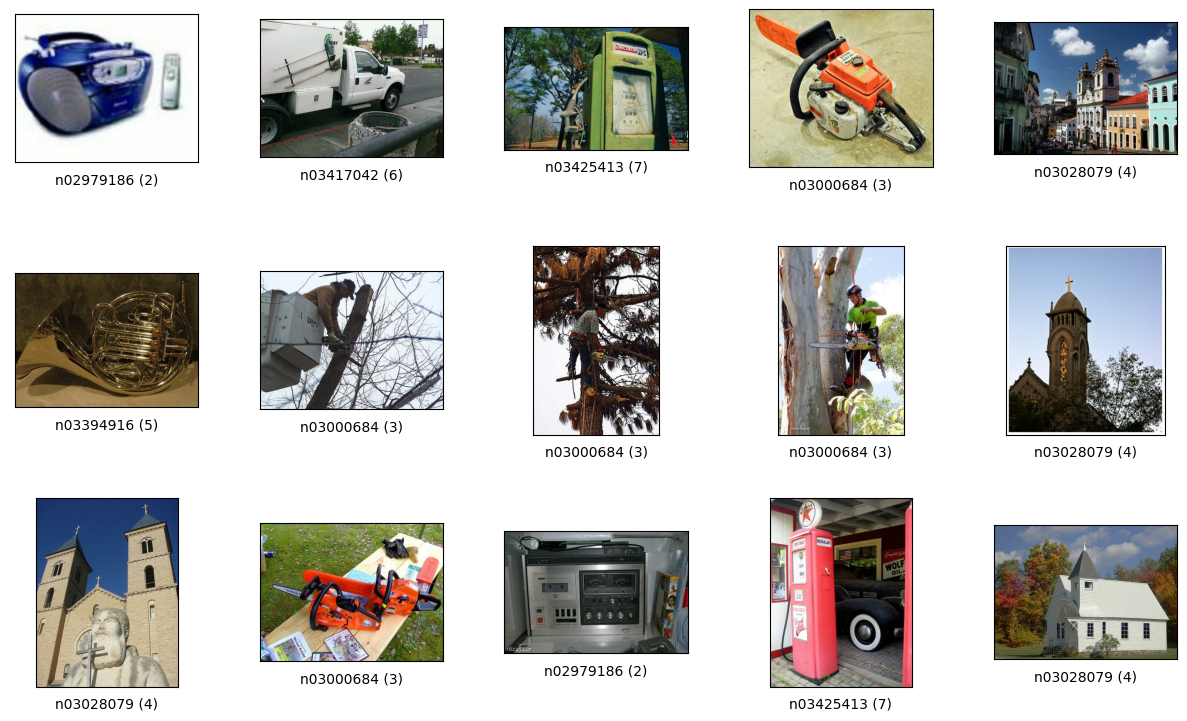

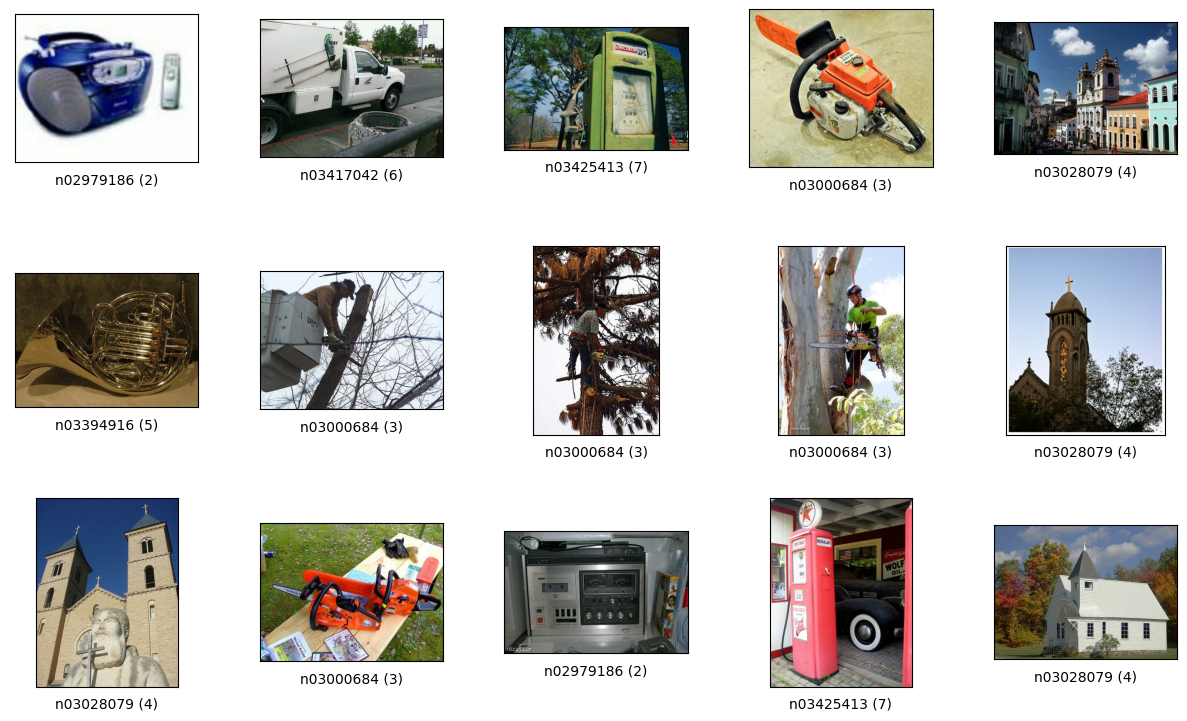

In [2]:
ds_and_info : tuple[defaultdict, tfds.core.DatasetInfo] = tfds.load(
    'imagenette/320px-v2', 
    shuffle_files=False, 
    with_info=True,
    as_supervised=True,
    batch_size=None,
)

ds, ds_info = ds_and_info

tfds.show_examples(ds['train'], ds_info, cols=5)

# Inception V3

![Inceptionv3_architecture.png](Inceptionv3_architecture.png)

In [3]:
inception_v3 = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet'
)

In [4]:
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [5]:
# inception_v3.save('inception_v3')

In [6]:
tf.keras.utils.plot_model(
    inception_v3, 
    show_shapes=True,
    # show_dtype=True,
    # expand_nested=True,
    show_layer_activations=True
)

# Get Activation Pathways

In [7]:
activation_pathway_full = model_to_graph(inception_v3)

In [8]:
names = set()

for node, node_data in activation_pathway_full.nodes(data=True):
    names.add(node_data['layer_type'])

names

{'Activation',
 'AveragePooling2D',
 'BatchNormalization',
 'Concatenate',
 'Conv2D',
 'Dense',
 'GlobalAveragePooling2D',
 'InputLayer',
 'MaxPooling2D'}

In [9]:
simple_activation_pathway_full = remove_intermediate_node(activation_pathway_full, lambda node: activation_pathway_full.nodes[node]['layer_type'] not in ['Conv2D', 'Dense', 'InputLayer', 'Concatenate'])

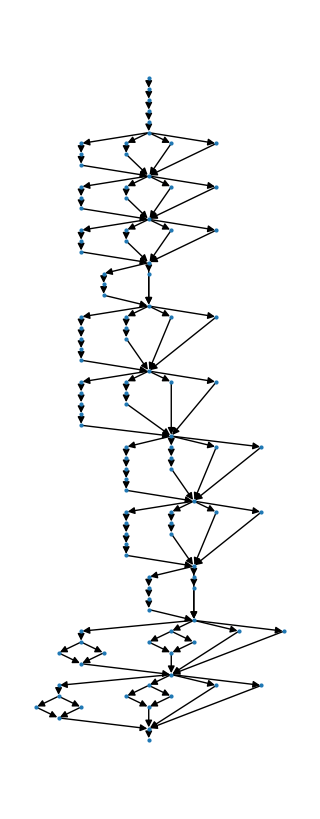

In [10]:
def get_model_layout(G):
    # TODO: Work on getting a better layout

    # Naive layout
    # pos = {}
    # input_node, _ = next(node for node in G.nodes(data=True) if node[1]['layer_type'] == 'InputLayer')
    # G.nodes[input_node]['level'] = 0
    # tree_depth = 0
    # for node in nx.topological_sort(G):
    #     if G.nodes[node]['layer_type'] == 'InputLayer':
    #         continue
    #     level = max(
    #         G.nodes[predecessor]['level'] 
    #         for predecessor in G.predecessors(node)
    #     ) + 1
    #     G.nodes[node]['level'] = level
    #     tree_depth = max(tree_depth, level)
    # pos = nx.multipartite_layout(G, subset_key="level", align='horizontal', scale=-1)


    # Get nodes by level
    # nodes_by_level = [[] for tree_depth in range(tree_depth + 1)]

    # for node, node_data in simple_activation_pathway_full.nodes(data=True):
    #     nodes_by_level[node_data['level']].append(node)

    # [[nx.get_node_attributes(simple_activation_pathway_full, 'name')[node] for node in nodes] for nodes in nodes_by_level]


    # Sugiyama Layout from grandalf library
    g = grandalf.utils.convert_nextworkx_graph_to_grandalf(G)
    for v in g.V(): v.view = type("defaultview", (object,), {"w": 10, "h": 10})
    sug = SugiyamaLayout(g.C[0])
    sug.init_all()
    sug.draw() # This only calculated the positions for each node.
    pos = {v.data: (v.view.xy[0], -v.view.xy[1]) for v in g.C[0].sV} # Extracts the positions
    return pos

plt.figure(figsize=(3,8))
nx.draw(simple_activation_pathway_full, pos=get_model_layout(simple_activation_pathway_full), node_size=4)
plt.show()

# Preprocessing

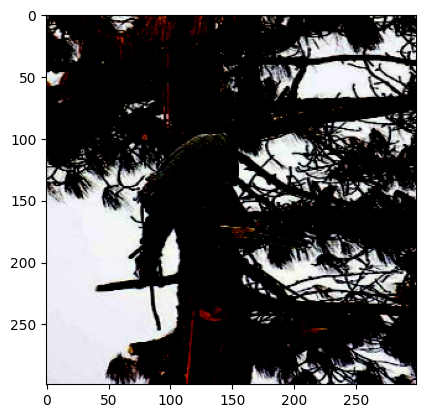

In [11]:
example_img, example_label = get_example(ds['train'])

example_img = preprocess(example_img, size=inception_v3.input.shape[1:3].as_list())
plt.imshow(example_img)

# Test Model Prediction

In [12]:
input_img: np.ndarray = tf.reshape(example_img, [1, *example_img.shape]).numpy()
pred: tf.Tensor = inception_v3(input_img)

print('Predicted', pred_to_name(tf.math.argmax(pred[0]).numpy()))
print('True', class_id_to_name(ds_info.features['label'].names[example_label]))

2023-02-06 10:35:11.378245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-06 10:35:11.661559: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Predicted chain_saw
True chain_saw


# Get each layer output

In [92]:
input_img = Image.open("cat.jpg")
input_img = preprocess(input_img, size=inception_v3.input.shape[1:3].as_list())
input_img = tf.reshape(input_img, [1, *input_img.shape]).numpy()
pred = inception_v3(input_img)

print('Predicted', pred_to_name(tf.math.argmax(pred[0]).numpy()))
print('True cat')

Predicted tabby
True cat


In [93]:
inception_v3.compile(loss="categorical_crossentropy", optimizer="adam")

# layers = ['conv2d_6', 'conv2d_93']
layers = None

activations = keract.get_activations(inception_v3, input_img, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)


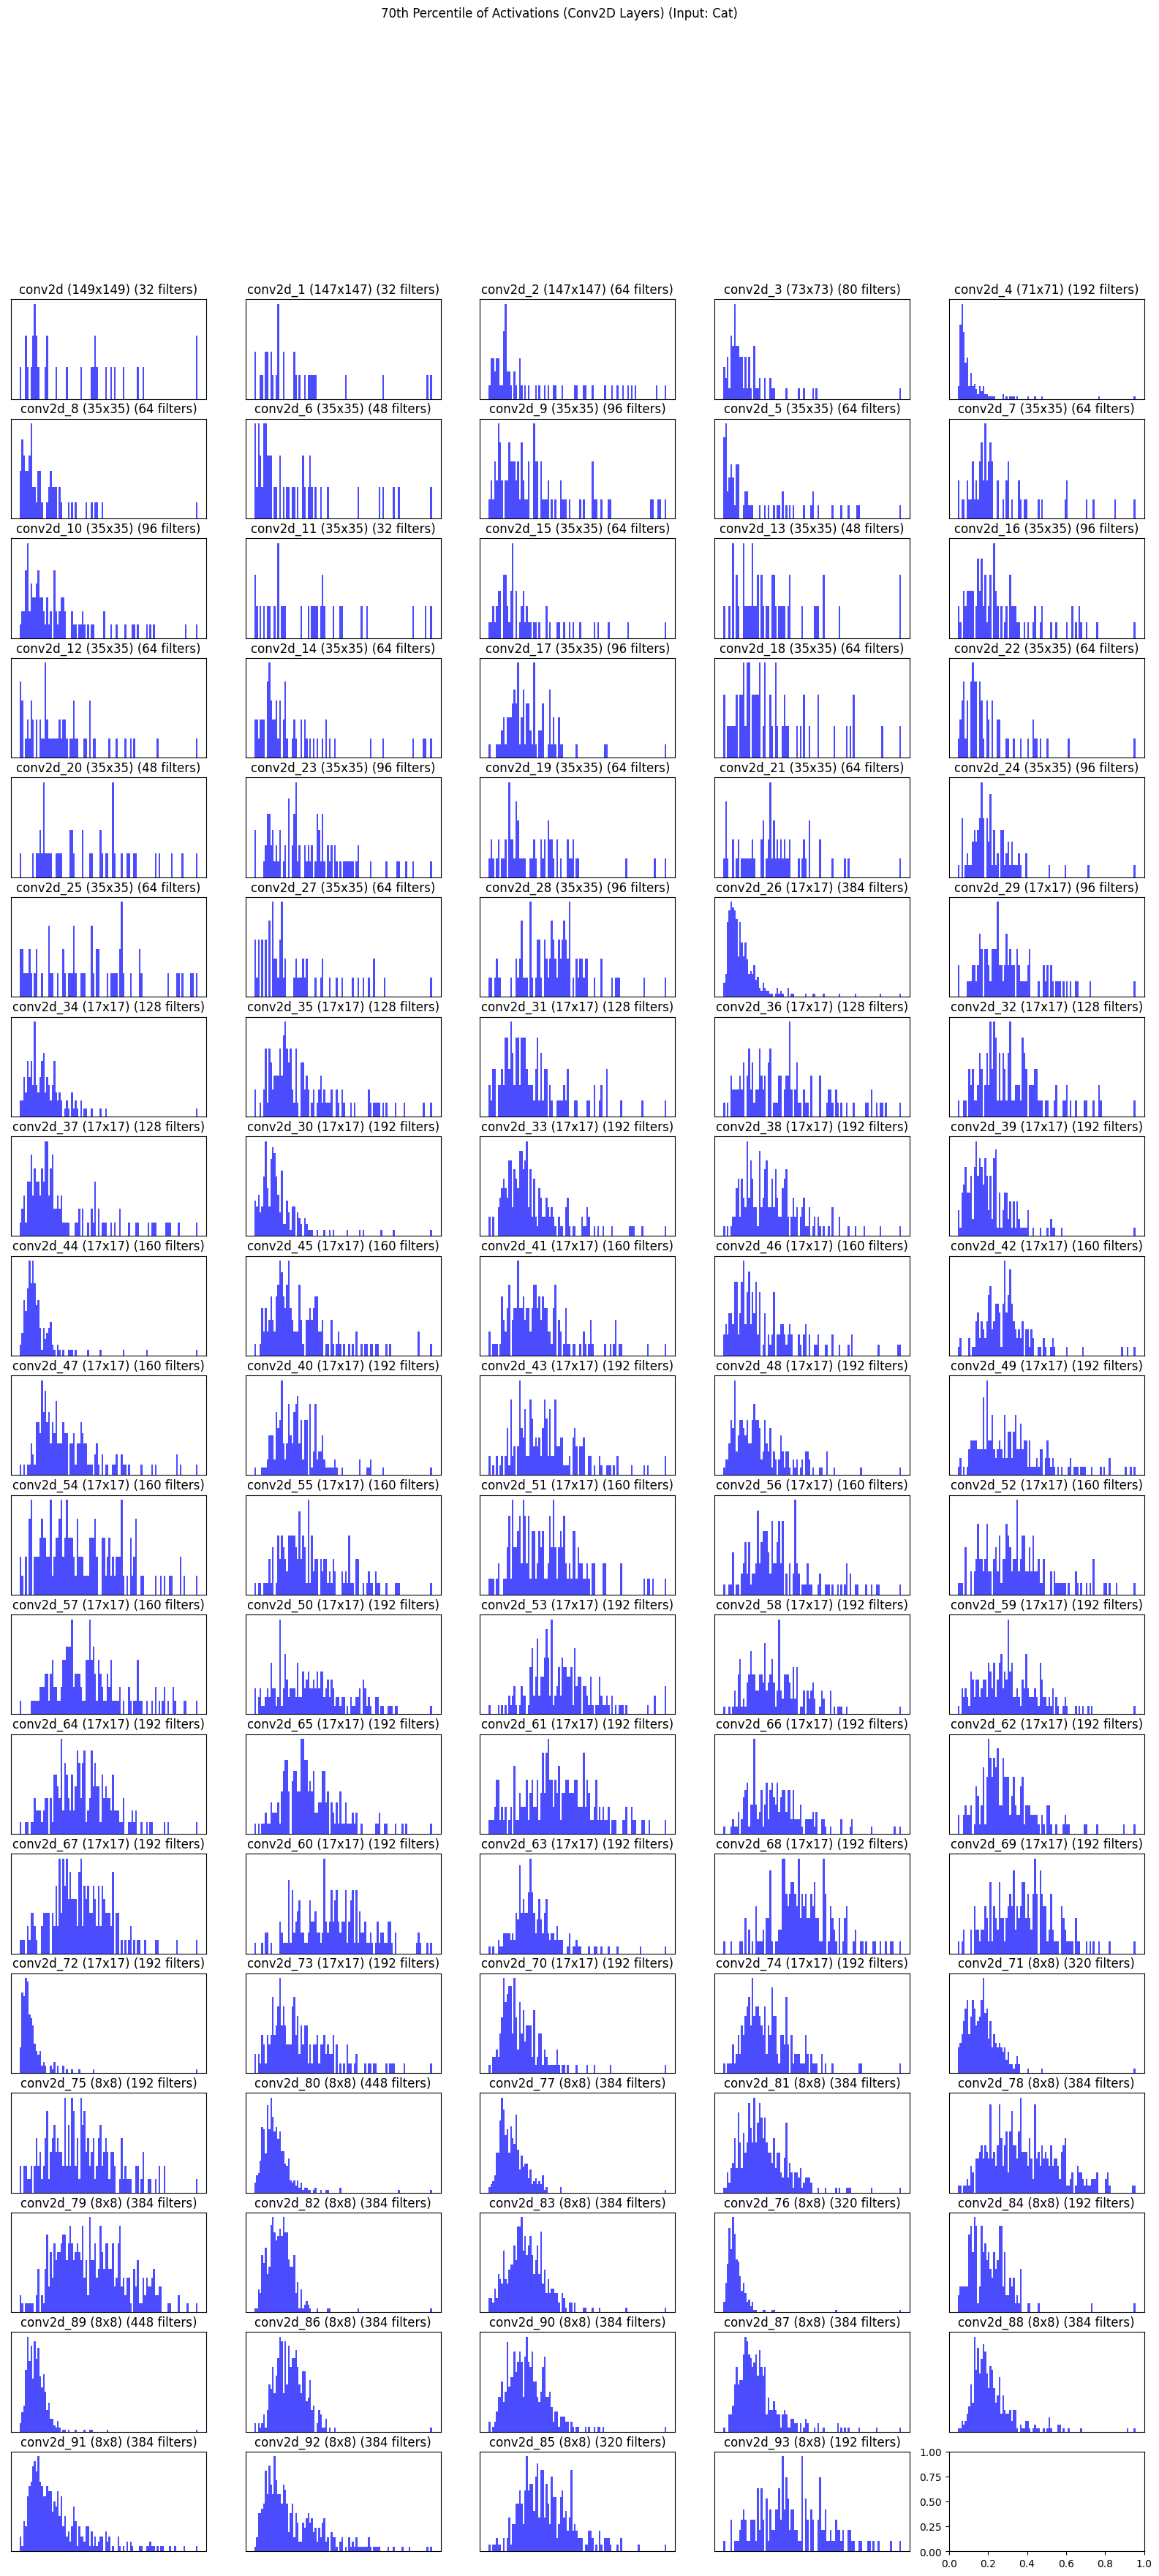

In [94]:
summary_fn = lambda x: np.percentile(np.abs(x), 70, axis=range(len(x.shape)-1))
# summary_fn = lambda x: np.mean(np.abs(x), axis=tuple(range(len(x.shape)-1)))
conv2D_activations = [layer for layer in activations if 'conv2d' in layer]

cols = 5
rows = len(conv2D_activations) // cols + 1

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 40),
    # sharex=True,
    # sharey=True
)
axes = axes.flatten()
fig.suptitle("70th Percentile of Activations (Conv2D Layers) (Input: Cat)")
# fig.suptitle("Mean of Activations (Conv2D Layers) (Input: Cat)")
# fig.suptitle("Median of Activations (Conv2D Layers) (Input: Cat)")

for layer, ax in zip(conv2D_activations, axes):
    summary = summary_fn(activations[layer])
    ax.hist(summary, bins=100, color='blue', alpha=0.7)
    ax.set_title(f"{layer} ({activations[layer].shape[1]}x{activations[layer].shape[2]}) ({summary.shape[0]} filters)")

    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

/tmp/ipykernel_295630/2373993599.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(cur_activations.shape[3] // nrows + 1, nrows, i+1)


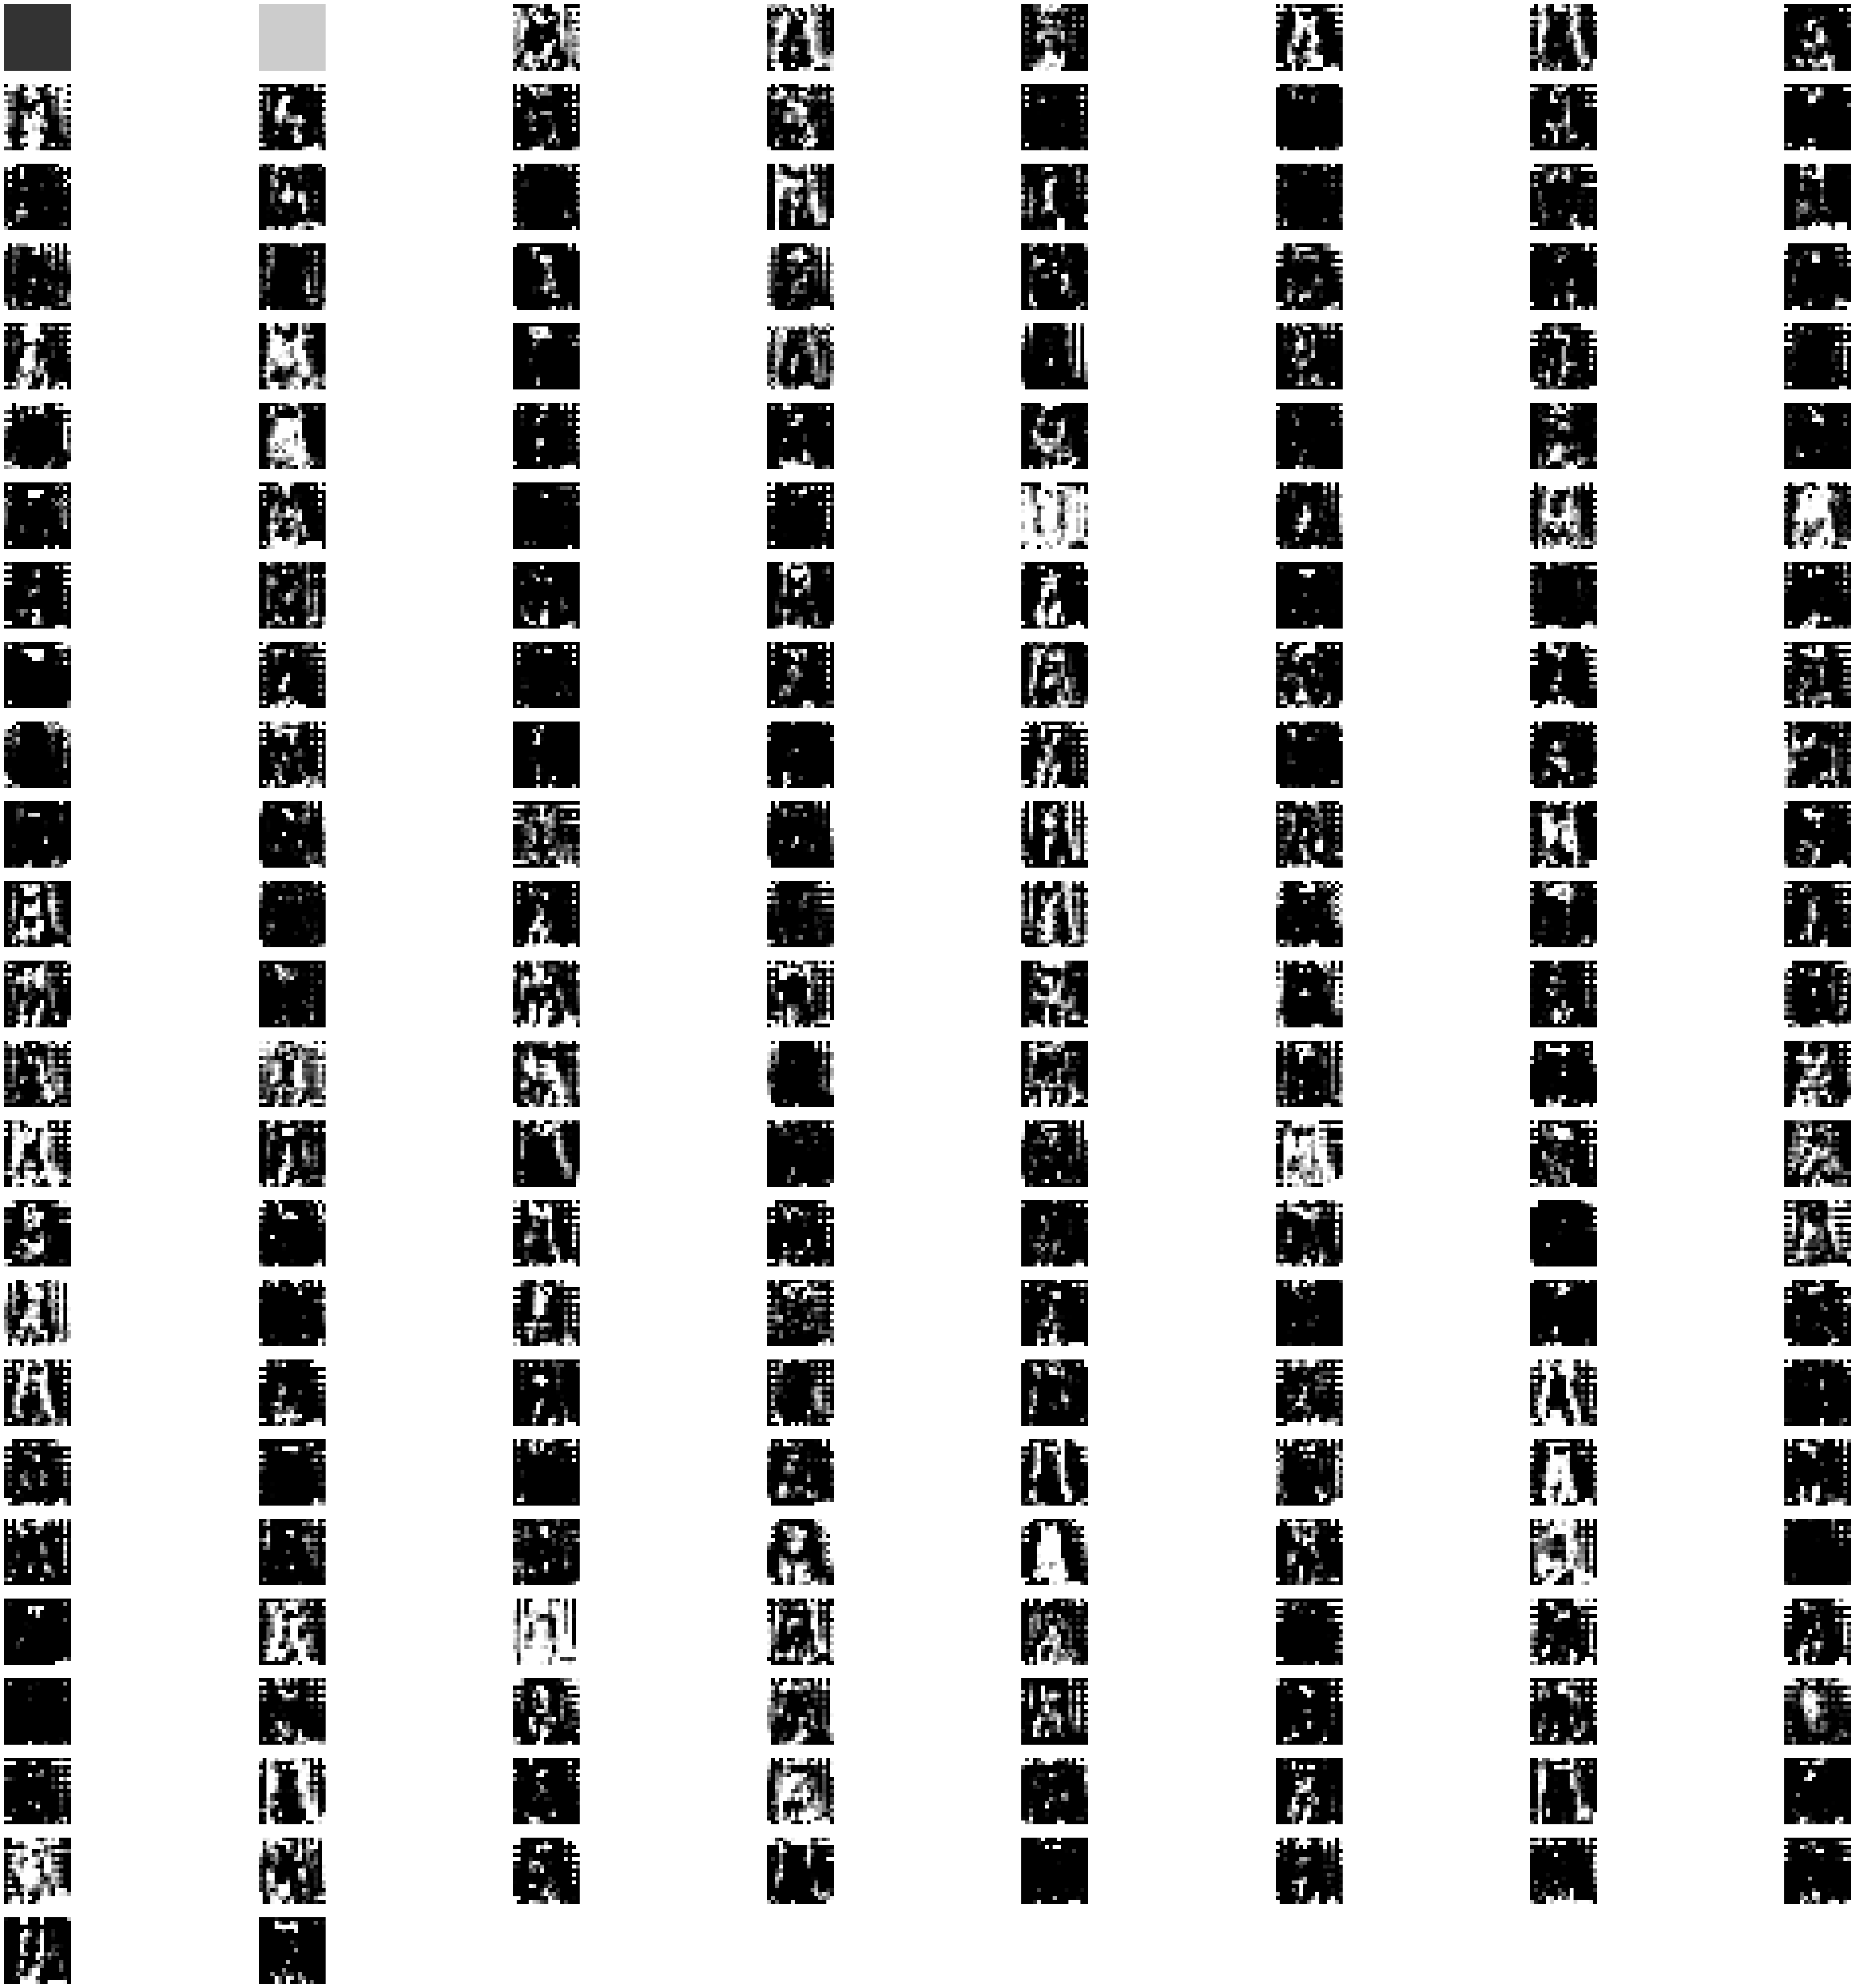

In [95]:
layer = 'activation_50'
nrows = 8
cur_activations = np.abs(activations[layer])
cur_activations = (cur_activations - np.percentile(cur_activations, 10)) / (np.percentile(cur_activations, 90) - np.percentile(cur_activations, 10))
cur_activations = np.concatenate([(np.ones((*cur_activations.shape[:3],1))*0.2), (np.ones((*cur_activations.shape[:3],1))*0.8), cur_activations], axis=3)

# Plot all the images from layer in grid with nrows columns
fig, ax = plt.subplots(figsize=(60, 60))
for i in range(cur_activations.shape[3]):
    ax = plt.subplot(cur_activations.shape[3] // nrows + 1, nrows, i+1)
    ax.imshow(
        cur_activations[0,:,:,i],
        interpolation='nearest',
        cmap='gray',
        vmin=0,
        vmax=1,
    )
    ax.axis('off')
plt.show()


activation_50 (1, 17, 17, 192) 


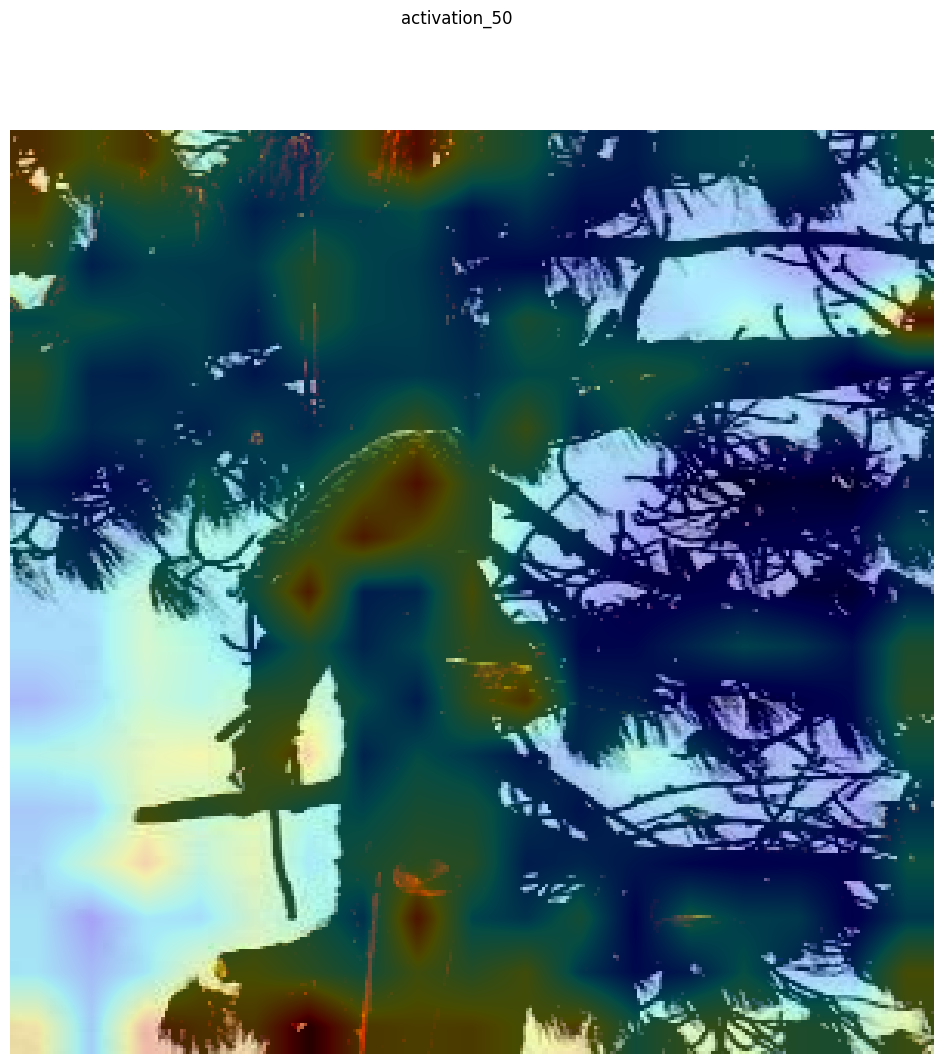

In [18]:
keract.display_heatmaps({layer: activations[layer]}, input_img[0], fix=False, merge_filters=True)

# Filtering activation layers

In [121]:
values.max()

2.6187503814697264

In [130]:
values = summary_fn(cur_activations)
np.percentile(values, 70)

0.19592049539089199

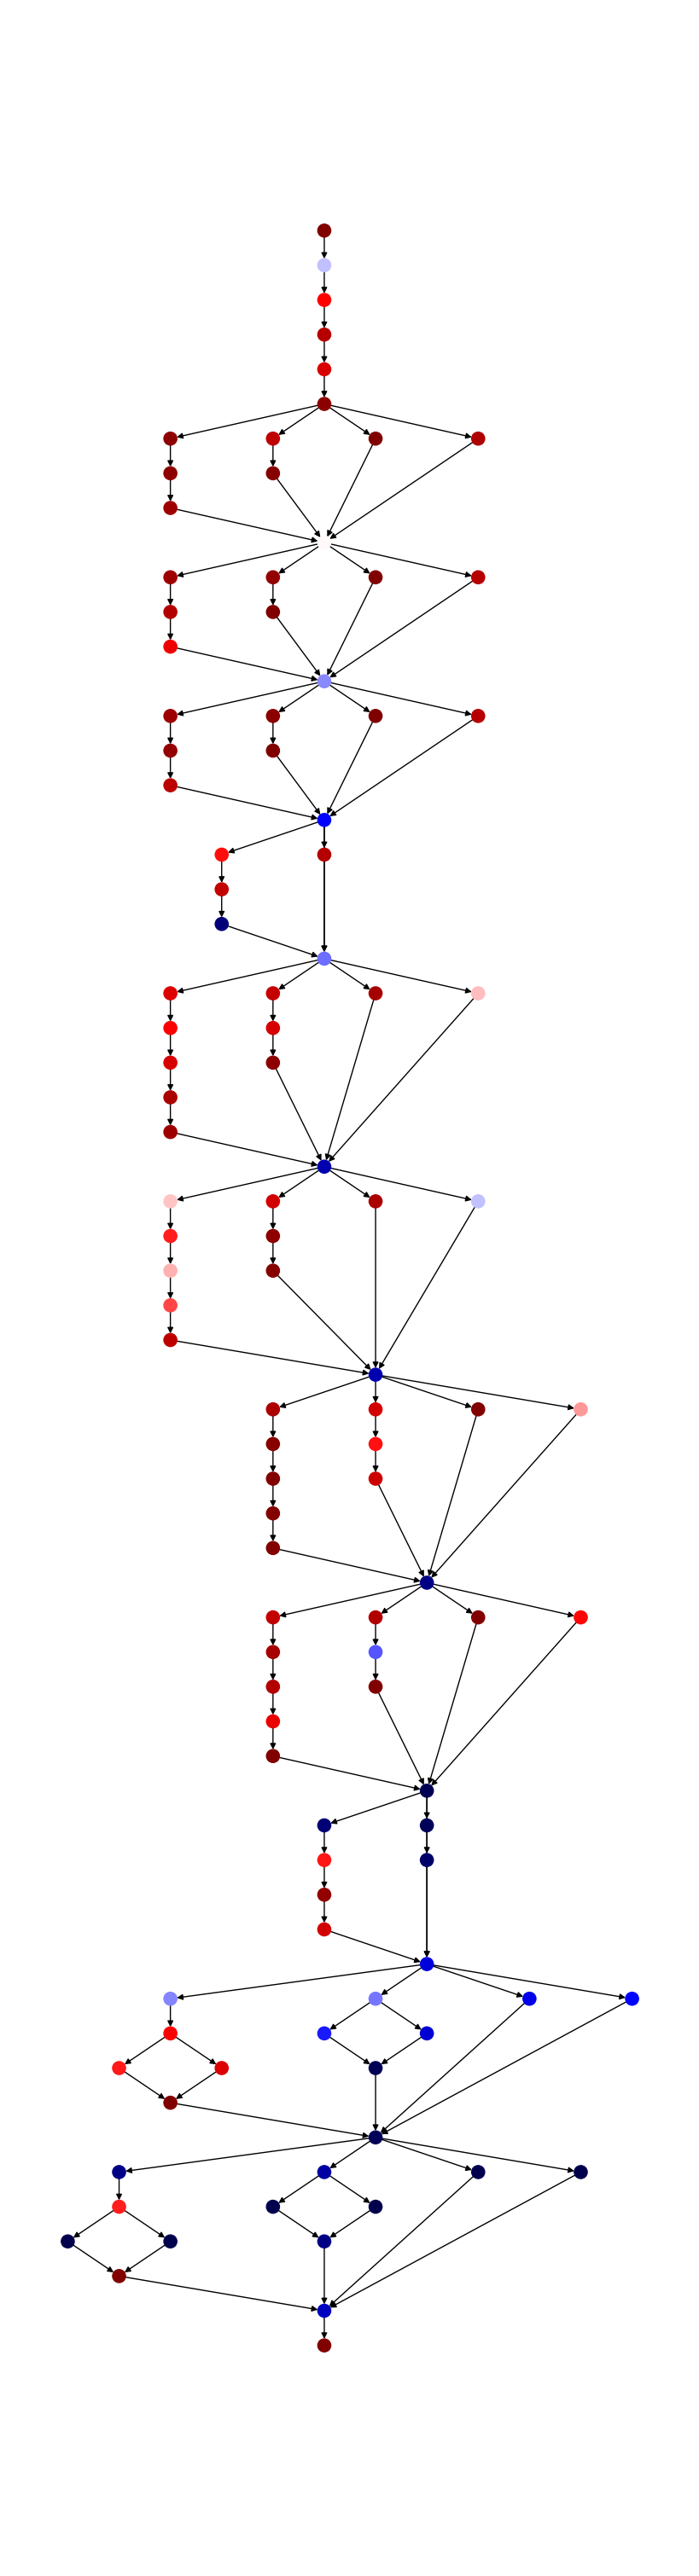

In [148]:
THRESHOLD = 0.5
TOP_BOT_CUT = 0

simple_activation_pathway_full_img1 = simple_activation_pathway_full.copy()

for node, data in simple_activation_pathway_full_img1.nodes(data=True):
    if 'conv' in data['name'] or 'mixed' in data['name']:
        cur_activations = activations[data['name']]
        # cur_activations = np.clip((cur_activations - np.percentile(cur_activations, TOP_BOT_CUT)) / (np.percentile(cur_activations, 100 - TOP_BOT_CUT) - np.percentile(cur_activations, TOP_BOT_CUT)), 0, 1)
        values = summary_fn(cur_activations)

        dynamic_threshold = np.percentile(values, 100 * THRESHOLD)

        # values = values > dynamic_threshold
        values = values > THRESHOLD

        simple_activation_pathway_full_img1.nodes[node]['activated'] = values
    else:
        simple_activation_pathway_full_img1.nodes[node]['activated'] = np.array([True])


plt.figure(figsize=(8,30))
activated_count = np.array([data['activated'].sum()/len(data['activated']) for node, data in simple_activation_pathway_full_img1.nodes(data=True)])
activated_count = (activated_count - activated_count.min()) / (activated_count.max() - activated_count.min())

cmap = list(map(mpl.colormaps['seismic'], activated_count))
nx.draw(
    simple_activation_pathway_full_img1,
    pos=get_model_layout(simple_activation_pathway_full_img1),
    node_size=120,
    node_color=cmap,
    # labels=nx.get_node_attributes(simple_activation_pathway_full_img1, 'name'),
    # connectionstyle="arc3,rad=0.1"
)
plt.show()

['input_1   1/1', 'conv2d   14/32', 'conv2d_1   24/32', 'conv2d_2   57/64', 'conv2d_3   66/80', 'conv2d_4   187/192', 'conv2d_8   62/64', 'conv2d_6   42/48', 'conv2d_9   93/96', 'conv2d_5   64/64', 'conv2d_7   63/64', 'conv2d_10   90/96', 'conv2d_11   29/32', 'mixed0   129/256', 'conv2d_15   60/64', 'conv2d_13   46/48', 'conv2d_16   86/96', 'conv2d_12   64/64', 'conv2d_14   64/64', 'conv2d_17   75/96', 'conv2d_18   57/64', 'mixed1   111/288', 'conv2d_22   60/64', 'conv2d_20   47/48', 'conv2d_23   92/96', 'conv2d_19   64/64', 'conv2d_21   64/64', 'conv2d_24   85/96', 'conv2d_25   57/64', 'mixed2   72/288', 'conv2d_27   47/64', 'conv2d_28   83/96', 'conv2d_26   344/384', 'conv2d_29   6/96', 'mixed3   273/768', 'conv2d_34   104/128', 'conv2d_35   97/128', 'conv2d_31   110/128', 'conv2d_36   106/128', 'conv2d_32   106/128', 'conv2d_37   117/128', 'conv2d_30   177/192', 'conv2d_33   186/192', 'conv2d_38   180/192', 'conv2d_39   108/192', 'mixed4   105/768', 'conv2d_44   89/160', 'conv2d_45 

/tmp/ipykernel_295630/2642216706.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


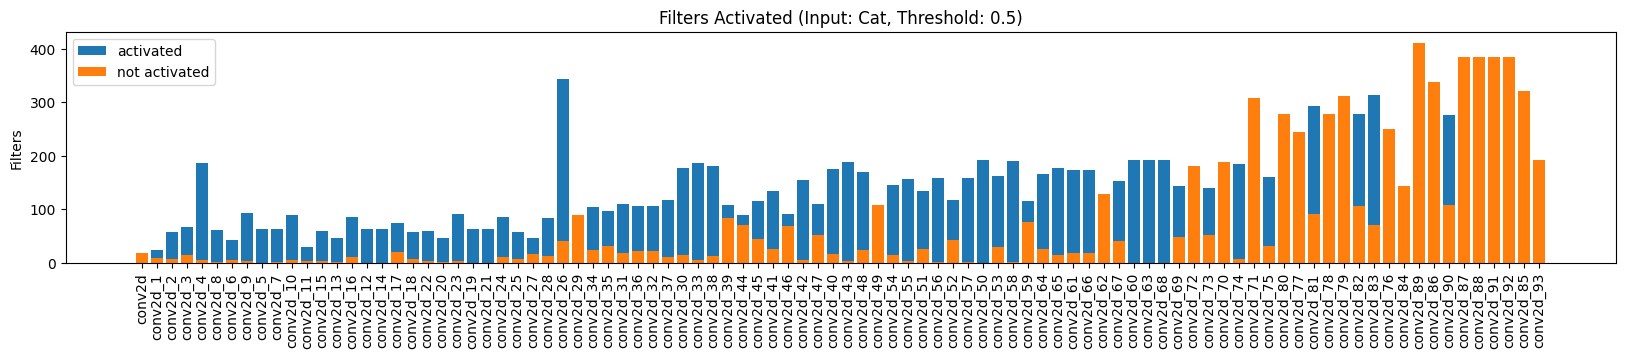

In [149]:
print([f"{data['name']}   {data['activated'].sum()}/{len(data['activated'])}" for node, data in simple_activation_pathway_full_img1.nodes(data=True) if 'activated' in data])
activated = {data['name']: (data['activated'].sum(), len(data['activated'])-data['activated'].sum()) for node, data in simple_activation_pathway_full_img1.nodes(data=True) if 'activated' in data}

conv2D_activated = {k: v for k, v in activated.items() if 'conv2d' in k}

labels = [k for k in conv2D_activated.keys()]
activated = [v[0] for v in conv2D_activated.values()]
deactivated = [v[1] for v in conv2D_activated.values()]

fig, ax = plt.subplots(figsize=(20, 3))
ax.bar(labels, activated, label="activated")
ax.bar(labels, deactivated, label="not activated")
ax.set_ylabel("Filters")
ax.set_xticklabels(labels, rotation=90)
ax.set_title(f"Filters Activated (Input: Cat, Threshold: {THRESHOLD})")
ax.legend()
plt.show()

In [150]:
def compare_activation_layer(layer1_activation_summary, layer2_activation_summary):
    return np.sqrt(((layer1_activation_summary - layer2_activation_summary)*(layer1_activation_summary - layer2_activation_summary)).sum())

In [151]:
compare_activation_layer(summary_fn(activations['conv2d_10']), summary_fn(activations['conv2d_10']))

0.0

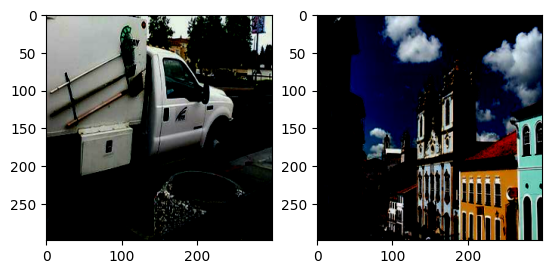

6 4


In [152]:
example_img1, example_label1 = get_example(ds['train'])
example_img2, example_label2 = get_example(ds['train'])

example_img1 = preprocess(example_img1, size=inception_v3.input.shape[1:3].as_list())
example_img2 = preprocess(example_img2, size=inception_v3.input.shape[1:3].as_list())
plt.subplot(121)
plt.imshow(example_img1)
plt.subplot(122)
plt.imshow(example_img2)
plt.show()

print(example_label1, example_label2)

238.11020317673683


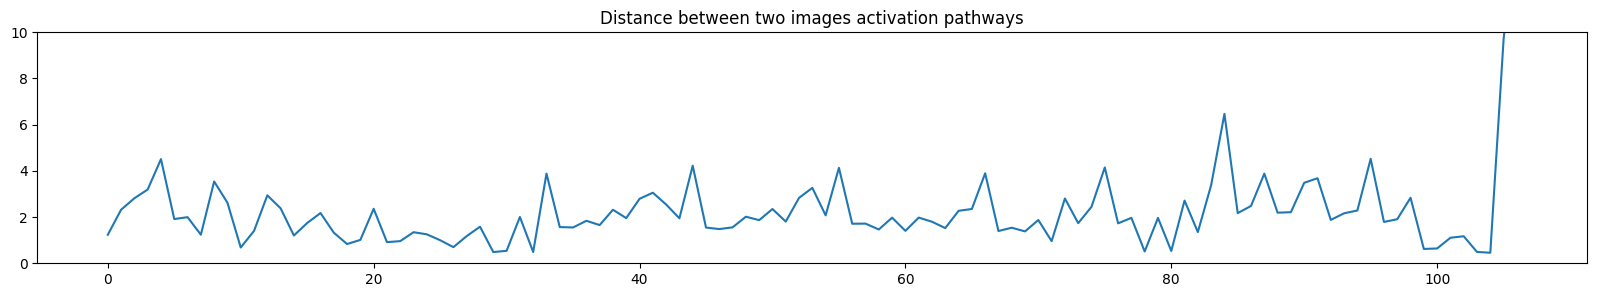

In [158]:
layers = None

activations1 = keract.get_activations(inception_v3, np.array([example_img1]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
activations2 = keract.get_activations(inception_v3, np.array([example_img2]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)


dist = {f"{i_name}-{j_name}": compare_activation_layer(summary_fn(layer_i), summary_fn(layer_j)) for i_name, layer_i in activations1.items() for j_name, layer_j in activations2.items() if ('conv' in i_name or 'mixed' in i_name) and i_name == j_name}

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(dist.values())
ax.set_ylim(0, 10)
ax.set_title("Distance between two images activation pathways")
print(sum(dist.values()))

In [26]:
activations1['mixed10'].shape

(1, 8, 8, 2048)

In [27]:
dist

{'conv2d-conv2d': 1.1901857,
 'conv2d_1-conv2d_1': 4.2970314,
 'conv2d_2-conv2d_2': 4.10164,
 'conv2d_3-conv2d_3': 5.7782145,
 'conv2d_4-conv2d_4': 7.218369,
 'conv2d_8-conv2d_8': 3.9318743,
 'conv2d_6-conv2d_6': 2.5119758,
 'conv2d_9-conv2d_9': 1.8685426,
 'conv2d_5-conv2d_5': 6.046351,
 'conv2d_7-conv2d_7': 4.8737283,
 'conv2d_10-conv2d_10': 1.0681646,
 'conv2d_11-conv2d_11': 1.8201287,
 'mixed0-mixed0': 4.37547,
 'conv2d_15-conv2d_15': 3.575426,
 'conv2d_13-conv2d_13': 1.5899432,
 'conv2d_16-conv2d_16': 2.550421,
 'conv2d_12-conv2d_12': 3.1004567,
 'conv2d_14-conv2d_14': 1.6578536,
 'conv2d_17-conv2d_17': 1.4290872,
 'conv2d_18-conv2d_18': 1.4237806,
 'mixed1-mixed1': 3.2712774,
 'conv2d_22-conv2d_22': 1.4941685,
 'conv2d_20-conv2d_20': 1.460874,
 'conv2d_23-conv2d_23': 2.2958903,
 'conv2d_19-conv2d_19': 2.0037565,
 'conv2d_21-conv2d_21': 1.2277062,
 'conv2d_24-conv2d_24': 1.1349047,
 'conv2d_25-conv2d_25': 1.5892612,
 'mixed2-mixed2': 2.3121603,
 'conv2d_27-conv2d_27': 0.6370697,
 